In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [3]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Question", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [4]:
print("Label 0 corresponds to ", raw_train_ds.class_names[0])
print("Label 1 corresponds to ", raw_train_ds.class_names[1])

Label 0 corresponds to  csharp
Label 1 corresponds to  java


In [5]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [6]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow/test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [7]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [8]:
max_features = 10000
sequence_length = 125

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [9]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [11]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Quenstion", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Quenstion tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 125), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,

In [12]:
print("0 ---> ", vectorize_layer.get_vocabulary()[0])
print("1 ---> ", vectorize_layer.get_vocabulary()[1])
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print("9999 ---> ", vectorize_layer.get_vocabulary()[9999])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

0 --->  
1 --->  [UNK]
1287 --->  scissors
 313 --->  source
9999 --->  essential
Vocabulary size: 10000


In [13]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
200/200 [==============================] - 1s 3ms/step - loss: 1.3760 - accuracy: 0.3744 - val_loss: 1.3576 - val_accuracy: 0.4963
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 1.3257 - accuracy: 0.5397 - val_loss: 1.2865 - val_accuracy: 0.5525

In [18]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 0s 2ms/step - loss: 0.5962 - accuracy: 0.7815
Loss:  0.5962439775466919
Accuracy:  0.781499981880188


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

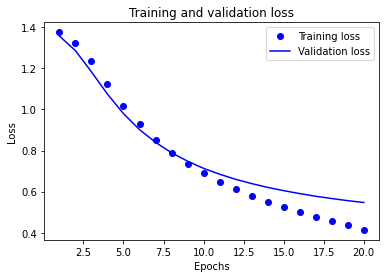

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

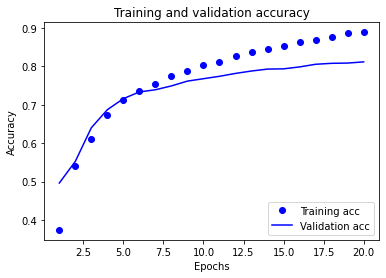

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [22]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 0.5962 - accuracy: 0.7815

In [23]:
examples = [
    "how to specify the connection string if the excel file name contains white space?using blank string connstring = ""provider=microsoft.ace.oledb.12.0;data source=d:\data\[proj_resource details 20110118.xlsx];extended properties=excel 12.0"";...i mentioned [ ] still it is throwing exception.how can i solve this problem..plz mention the correct path",
    "http get response parsing in blank and store in a string i have this below response from a http get request..response=you are about to purchase abcd package for 20 usd. charge :1usd&amp;encoding=0&amp;sessionop=end...i'm trying to get only ""you are about to purchase abcd package for 20 usd. charge :1usd"" to a string in blank so that i can display it to the customer, but i'm not sure how...any help would be appreciated. thank you",
    "why is length equal to 0 in browser before it is defined? i would expect the value of an undefined variable in blank to behave like this when it is logged:....but on jsfiddle it is showing the length is 0 before it is ever defined.....after more research. it also seems to default to 0 in chrome.....when i would expect it to generate an error like with any other randomword....when i run the same commands in node locally, it seems to behave how i would expect. with throwing an error for length:....why is length equal to 0 in these cases?"
]

import numpy as np
np.argmax(export_model.predict(examples), axis=1)

array([0, 3, 2])